# Hierarchical Clustering Evaluation: Cost and Revenue Functions

In hierarchical clustering, evaluating the quality of a clustering tree is crucial for ensuring that similar data points are grouped together while dissimilar ones are separated effectively. Two complementary measures to assess the quality of such clustering structures are **Dasgupta's cost function** and the **Moseley-Wang revenue function**. Both metrics leverage pairwise similarities between data points and the structure of the clustering tree, but they capture different aspects of clustering quality.

## Dasgupta's Cost Function

Dasgupta's cost function provides a quantitative measure of how well a hierarchical clustering captures the inherent similarity between data points. Consider an undirected graph $G = (V, E)$, where $V$ represents the data points and $E$ contains edges weighted by the similarity $w_{ij}$ between points $i$ and $j$. The cost associated with a clustering tree $T$ (whose leaves correspond to the original data points) is defined as:

![Dasgupta's Cost Function](https://latex.codecogs.com/svg.image?\text{Cost}_{\text{Dasgupta}}(T)=\sum_{i<j}w_{ij}\cdot|T_{ij}|)

Here, $|T_{ij}|$ denotes the number of leaves in the subtree rooted at the lowest common ancestor of $i$ and $j$ in $T$.

## Moseley-Wang Revenue Function

Complementing the cost function, the Moseley-Wang revenue function offers an alternative perspective by rewarding clusterings that efficiently separate dissimilar points. It is given by:

![Moseley-Wang Revenue Function](https://latex.codecogs.com/svg.image?\text{Revenue}_{\text{Moseley-Wang}}(T)=\sum_{i<j}w_{ij}\cdot(n-|T_{ij}|))

In this equation, $n$ denotes the total number of data points, and $|T_{ij}|$ is defined as above.

## A Unified Perspective

By considering both metrics together, one gains a comprehensive understanding of clustering quality:

- **Dasgupta's Cost Function** focuses on **minimizing the cost** by ensuring that similar points are grouped together as early as possible. A lower cost indicates that the clustering effectively captures data similarities.
- **Moseley-Wang Revenue Function** focuses on **maximizing the revenue** by rewarding clusterings that separate dissimilar points early in the hierarchy. A higher revenue signifies that the clustering structure is effective at isolating different groups.

Together, these functions provide complementary insights into the performance of a hierarchical clustering method. They help balance the trade-off between creating tight clusters of similar points and ensuring that distinct clusters are well separated.

In this project, our goal is to implement both the cost and revenue functions in Python, enabling a thorough evaluation of hierarchical clustering results.

## References

- **Dasgupta's Cost Function:**  
  Sanjoy Dasgupta. "[A Cost Function for Similarity-Based Hierarchical Clustering](https://arxiv.org/abs/1510.05043)" (October 20, 2015).

- **Moseley-Wang Revenue Function:**  
  Benjamin Moseley and Y. Wang. "[Hierarchical Clustering with Revenue Maximization](https://arxiv.org/abs/1706.04722)" (2017).


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.metrics.pairwise import rbf_kernel


### Create a pandas DataFrame with 30 samples and 5 features


In [2]:
np.random.seed(42)
df = pd.DataFrame(np.random.rand(30, 5), 
                  columns=["X 1", "X 2", "X 3", "X 4", "X 5"])
df.head()

,X 1,X 2,X 3,X 4,X 5
0,0.374540,0.950714,0.731994,0.598658,0.156019
1,0.155995,0.058084,0.866176,0.601115,0.708073
2,0.020584,0.969910,0.832443,0.212339,0.181825
3,0.183405,0.304242,0.524756,0.431945,0.291229
4,0.611853,0.139494,0.292145,0.366362,0.456070


### Build a tree structure from the linkage matrix


In [3]:
# Define a Node class to hold tree information
class Node:
    def __init__(self, left=None, right=None, data=None, dist=0.0):
        self.left = left         # left child
        self.right = right       # right child
        self.data = data         # for leaves: holds the label; for internals: None
        self.dist = dist         # the merge distance (for internal nodes)
        if left is None and right is None:
            self.n_leaves = 1
            self.leaf_indices = []  # will store the original index for leaves
        else:
            self.n_leaves = 0
            self.leaf_indices = []
    def __repr__(self):
        if self.data is not None:
            return f"{self.data}"
        else:
            return self.n_leaves , self.dist

### Define functions to find the lowest common ancestor (LCA) & $ |T_{ij}| $


In [4]:
def find_path(root, target):
    if root == target:
        return [root]
    if root.left is not None:
        left_path = find_path(root.left, target)
        if left_path is not None:
            return [root] + left_path
    if root.right is not None:
        right_path = find_path(root.right, target)
        if right_path is not None:
            return [root] + right_path
    return None

def lca(root, leaf1, leaf2):
    path1 = find_path(root, leaf1)
    path2 = find_path(root, leaf2)
    lca_node = None
    for n1, n2 in zip(path1, path2):
        if n1 == n2:
            lca_node = n1
        else:
            break
    return lca_node

### Function to Build a Tree from a Linkage Matrix with Leaf Nodes Storing Original Indices

In [5]:
def build_tree(Z, labels):
    n = len(labels)
    nodes = {}
    # Create leaf nodes for indices 0 to n-1
    for i in range(n):
        node = Node(data=labels[i], dist=0.0)
        node.leaf_indices = [i]
        nodes[i] = node
    # Each row in Z represents a merge of two clusters
    for i, row in enumerate(Z):
        idx1, idx2, dist, count = row
        idx1, idx2 = int(idx1), int(idx2)
        new_node = Node(left=nodes[idx1], right=nodes[idx2], dist=dist)
        new_node.leaf_indices = nodes[idx1].leaf_indices + nodes[idx2].leaf_indices
        new_node.n_leaves = len(new_node.leaf_indices)
        nodes[n + i] = new_node
    root = nodes[max(nodes.keys())]
    return root, nodes

### Compute the linkage matrix using average linkage

In [6]:
labels = [f"Sample {i}" for i in range(len(df))]
Z = linkage(df.values, method='average')
root, nodes = build_tree(Z, labels)

### Plot dendrogram with vertical leaf labels 

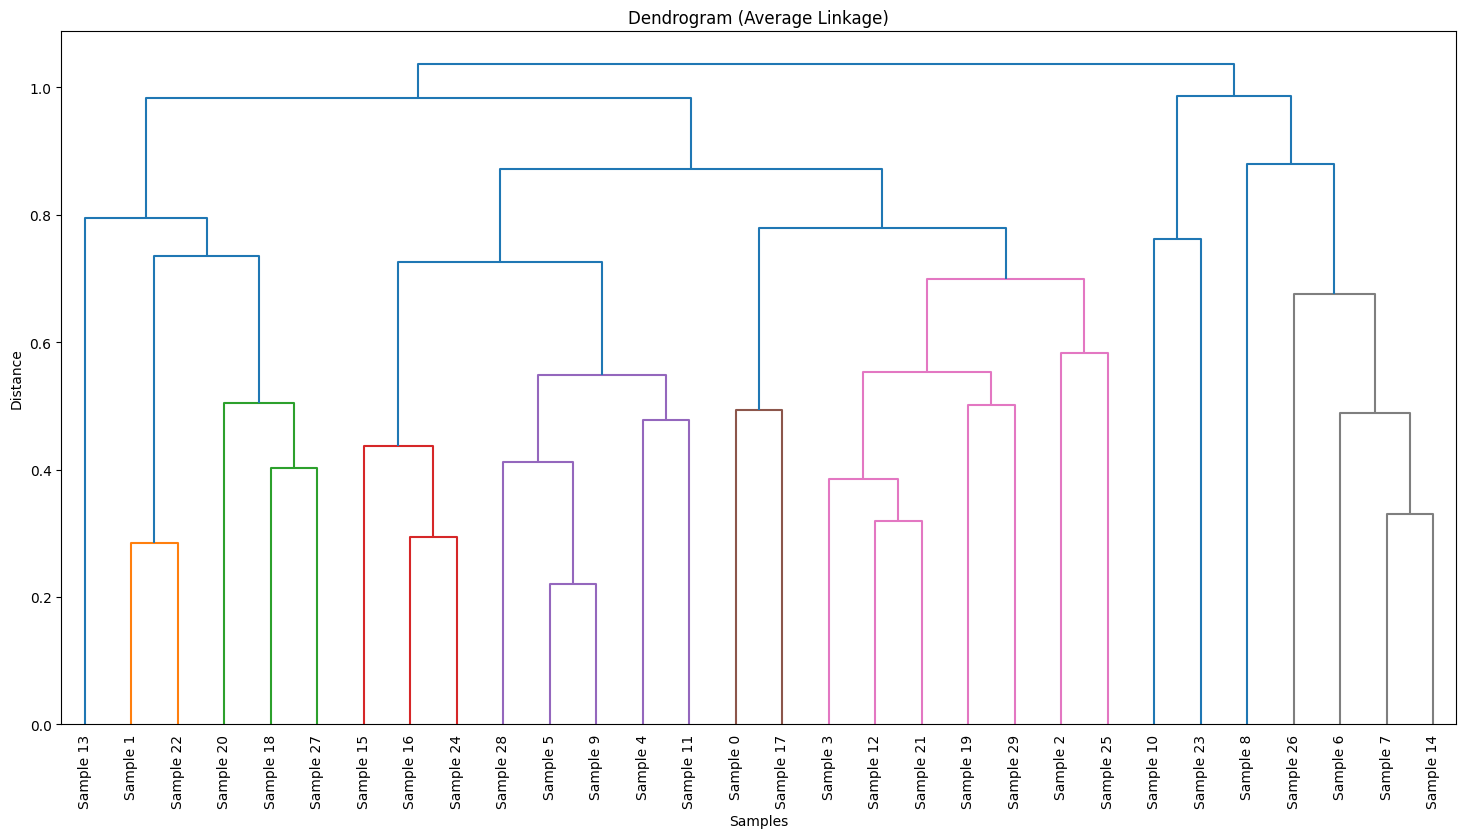

In [7]:
plt.figure(figsize=(18, 9))
data = dendrogram(Z, labels=labels, leaf_rotation=90)
plt.title("Dendrogram (Average Linkage)")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.show()


###  Examples of Calculating the Number of Leaves in the Subtree Rooted at the Lowest Common Ancestor (LCA) for Given Node Pairs


In [8]:

node_pairs = [(nodes[7], nodes[14]),
              (nodes[3], nodes[21]),
              (nodes[15], nodes[11]),
              (nodes[21], nodes[2])]

for u, v in node_pairs:
    print(f" | T ({u},{v}) | = {lca(root, u, v).n_leaves}")

 | T (Sample 7,Sample 14) | = 2
 | T (Sample 3,Sample 21) | = 3
 | T (Sample 15,Sample 11) | = 8
 | T (Sample 21,Sample 2) | = 7


![My image](images/output.png)


###  Hierarchical Clustering Metrics Implementation


In [9]:
def calculate_metric(df, gamma, root, nodes, metric):
    W = rbf_kernel(df.values, gamma=gamma)  # Constructing a Gaussian similarity matrix
    n = W.shape[0]
    result = 0.0
    for i in range(n):
        for j in range(i + 1, n):
            n_leaves = lca(root, nodes[i], nodes[j]).n_leaves
            result += W[i, j] * metric(n, n_leaves)
    return result


In [10]:
# List of gamma values to test
gammas = [0.5, 0.7, 0.8, 1, 1.2, 1.5]

### Compute Dasgupta's cost  $$ \text{Cost}_{Dasgupta}(T) = \sum_{i<j} w_{ij} \cdot |T_{ij}| $$


In [11]:
# Calculate and print Dasgupta's cost for each gamma
print("Dasgupta's Cost:")
for gamma in gammas:
    cost = calculate_metric(df, gamma, root, nodes, metric=lambda n, n_leaves: n_leaves)
    print(f"Gamma: {gamma:.1f}, cost_Dasgupta: {cost:.2f}")

Dasgupta's Cost:
Gamma: 0.5, cost_Dasgupta: 5551.83
Gamma: 0.7, cost_Dasgupta: 4634.62
Gamma: 0.8, cost_Dasgupta: 4244.88
Gamma: 1.0, cost_Dasgupta: 3577.72
Gamma: 1.2, cost_Dasgupta: 3033.59
Gamma: 1.5, cost_Dasgupta: 2393.86


### Compute Moseley-Wang Revenue  $$ \text{Revenue}_{Moseley-Wang}(T) = \sum_{i<j} w_{ij} \cdot |n - T_{ij}| $$


In [12]:
# Calculate and print Moseley-Wang revenue for each gamma
print("\nMoseley-Wang Revenue:")
for gamma in gammas:
    revenue = calculate_metric(df, gamma, root, nodes, metric=lambda n, n_leaves: n - n_leaves)
    print(f"Gamma: {gamma:.1f}, Revenue_Moseley_Wang: {revenue:.2f}")


Moseley-Wang Revenue:
Gamma: 0.5, Revenue_Moseley_Wang: 2976.89
Gamma: 0.7, Revenue_Moseley_Wang: 2654.62
Gamma: 0.8, Revenue_Moseley_Wang: 2511.44
Gamma: 1.0, Revenue_Moseley_Wang: 2255.67
Gamma: 1.2, Revenue_Moseley_Wang: 2034.81
Gamma: 1.5, Revenue_Moseley_Wang: 1756.56
